# Braiding for Kapit-Mueller Model with First Band Approximation

In [2]:
using QuantumOptics
using NBInclude
using SparseArrays
using DataFrames
using Plots
using Interpolations
using LinearAlgebra
using LaTeXStrings
using ProgressBars
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude(joinpath("../Hofstadter","Torus_Distance.ipynb"))
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("../Hofstadter Many Body Utils.ipynb");

In [109]:
Nx = 4
Ny = 4
p = 1
q = 2
pn = 3
N_Pin = 2
U = 2

N_Site = Nx*Ny
t = 1
NPhi0 = Int(Nx*Ny*(p/q))
Cut_Off = NPhi0
PN = vcat( ( [i] for i in 0:pn) ... )

nu0 = 1/2 # The quasihole numbers depend on Laughlin fraction
NPhi = NPhi0-N_Pin
N_d = Int(NPhi - pn/nu0)
nu = pn//NPhi0
Degeneracy = Int((factorial(N_d + pn - 1) / (factorial(N_d) * factorial(pn - 1))) * (NPhi / pn))
println("Lattice: ",Nx,"x",Ny,
        "\nThe Number of Flux per Unit-Cell (p/q) = ",p//q,
        "\nFilling Fraction = ",nu," (The Number of Quasiholes = ",(N_Pin+N_d),
        ")\nThe Number of Flux Quanta = ", NPhi,
        " (Delocalised Number = ", N_d,
        ")\nThe Total Number of Particle = ",pn,
        "\nThe Number of State of Ground Degeneracy = ",Degeneracy)

Lattice: 4x4
The Number of Flux per Unit-Cell (p/q) = 1//2
Filling Fraction = 3//8 (The Number of Quasiholes = 2)
The Number of Flux Quanta = 6 (Delocalised Number = 0)
The Total Number of Particle = 3
The Number of State of Ground Degeneracy = 2


In [110]:
function KM(Nx, Ny, t, p, q)
    coordinates = vcat( ( [y x] for x in 0:Nx-1 for y in 0:Ny-1 ) ... )
    alpha = p/q
    H = spzeros(Complex{Float64}, N_Site, N_Site)
    for j in 1:N_Site
        for k in 1:N_Site
            if j!=k
                x_j = coordinates[j, 1] 
                y_j = coordinates[j, 2] 
                x_k = coordinates[k, 1]
                y_k = coordinates[k, 2]
                z_j = x_j + 1im*y_j
                z_k = x_k + 1im*y_k
                for n in range(-1,1)
                    for m in range(-1,1)
                        R = n * Nx + 1im * m * Ny
                        z = (z_k - z_j) + R 
                        G = (-1) ^ ( real(z) + imag(z) + real(z) * imag(z) )
                        beta = (pi/2) * ( (z_j * conj(z) ) - (conj(z_j) * z) )*alpha
                        W = t * G * exp( -pi/2 * (1-alpha) * (abs(z)^2) )
                        J = W * exp(beta) * exp( pi/2 * ( (z_j * conj(R) ) - (conj(z_j) * R) ) * alpha)
                        H[j,k] += J
                    end
                end
            end
        end
    end
    return H
end

KM (generic function with 1 method)

In [111]:
Sp_Basis = NLevelBasis(N_Site);

In [112]:
function Sp_Sub(N_Site, Nx, Ny, t, p, q, Sp_Basis, Cut_Off)
    Sp = KM(Nx, Ny, t, p, q)
    H_Sp = get_sp_op(Sp_Basis, Sp)
    H_Sp = dense((H_Sp+H_Sp')/2)
    Sub_States = get_sub_states(H_Sp, Cut_Off)
    Sub_Basis, P, Pt = get_projector_op(Sub_States, Sp_Basis)
    H_Sp_Sub = get_subspace_op(H_Sp, P, Pt)
    return H_Sp, Sub_Basis, P, Pt, H_Sp_Sub
end

Sp_Sub (generic function with 1 method)

In [113]:
H_Sp, Sub_Basis, P, Pt, H_Sp_Sub = Sp_Sub(N_Site, Nx, Ny, t, p, q, Sp_Basis, Cut_Off);
EEA, UUA = eigenstates(H_Sp);

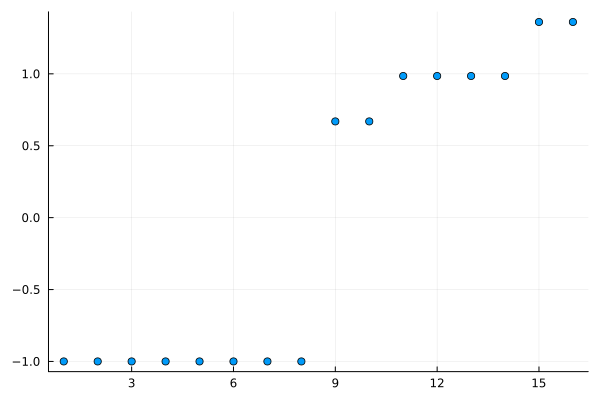

In [114]:
scatter(EEA,legend=false)

In [115]:
Sub_Number_Operator_List = get_num_sub_list(N_Site, Sp_Basis, P, Pt);

In [116]:
function get_MB_Sub(Sub_Basis, PN, H_Sp_Sub)
    MB_States = bosonstates(Sub_Basis, PN) 
    MB_Basis = ManyBodyBasis(Sub_Basis, MB_States)
    H_MB_Sub = get_mb_op(MB_Basis, H_Sp_Sub)
    return H_MB_Sub
end

get_MB_Sub (generic function with 1 method)

In [117]:
H_MB_Sub = get_MB_Sub(Sub_Basis, PN, H_Sp_Sub);

In [118]:
function get_Bosonic_MB_Basis(N_Site, PN)
    N_Basis = NLevelBasis(N_Site)
    N_States = bosonstates(N_Basis, PN)
    N_Basis_MB = ManyBodyBasis(N_Basis, N_States)
    return N_Basis_MB, N_Basis
end

get_Bosonic_MB_Basis (generic function with 1 method)

In [119]:
Basis_Cut_MB, Basis_Cut_Sp = get_Bosonic_MB_Basis(Cut_Off, PN)

(ManyBody(onebodybasis=NLevel(N=8), states:165), NLevel(N=8))

In [120]:
H_Kin = SparseOperator(Basis_Cut_MB)
H_Kin.data = H_MB_Sub.data;

In [121]:
H_Int = Hubbard_Interaction_op(P, Pt, Basis_Cut_MB, Cut_Off, U);

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
50.0%┣███████████████████████▌                       ┫ 4/8 [00:00<00:00, 52it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 67it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 67it/s]


$
k \leftrightarrow l,m \leftrightarrow n
$

In [16]:
P1 = P.data
P1t = Pt.data
@einsum coefficient[k,l,m,n] := P1[k,i] * P1[l,i] * P1t[i,m] * P1t[i,n]

8×8×8×8 Array{ComplexF64, 4}:
[:, :, 1, 1] =
   0.0692688-5.42168e-20im  …    5.71275e-9+1.12593e-8im
  1.79011e-7+4.40244e-8im      -0.000508218+1.67202e-9im
 -7.75732e-9+1.65897e-8im       -2.04924e-9-2.7089e-9im
  1.21176e-8+1.40307e-8im      -5.38883e-10-3.44175e-9im
  4.79136e-8-3.44504e-8im        -0.0121541+1.45876e-8im
 -7.22725e-9+8.71862e-9im   …    1.24643e-8+4.32545e-9im
  0.00678381-1.50097e-9im       -3.17921e-8-3.8369e-8im
  5.71275e-9+1.12593e-8im         0.0402661-1.83125e-8im

[:, :, 2, 1] =
  1.79011e-7-4.40244e-8im   …   0.00317153+1.64723e-9im
    0.078986+1.51788e-18im      5.07117e-9+3.78345e-9im
   4.0993e-9+3.25274e-9im       1.02916e-9-2.75828e-9im
  7.03244e-9-1.32365e-9im      -2.37138e-9-1.10952e-8im
  0.00401765-3.43454e-10im      2.29725e-8-7.7978e-9im
  3.06094e-9+2.86813e-8im   …     3.725e-9-3.72305e-9im
 -2.13002e-9+3.14326e-10im      -0.0129474-1.03317e-8im
  0.00317153+1.64723e-9im      -5.27014e-8+5.5174e-8im

[:, :, 3, 1] =
 -7.75732e-9-1.65897e-8

In [17]:
coefficient[1,3,4,5]

0.022487268959403457 + 2.5069852828234207e-8im

In [18]:
coefficient[3,1,5,4]

0.022487268959403457 + 2.506985282910157e-8im

In [19]:
A = [destroy(Basis_Cut_MB, k) for k in 1:Cut_Off]
At = [create(Basis_Cut_MB, k) for k in 1:Cut_Off];

In [20]:
At[1] * At[3] * A[4] * A[5]

Operator(dim=165x165)
  basis: ManyBody(onebodybasis=NLevel(N=8), states:165)sparse([12, 48, 55, 61, 62, 63, 64, 65, 66], [32, 68, 96, 117, 132, 136, 137, 138, 139], ComplexF64[1.0 + 0.0im, 1.4142135623730951 + 0.0im, 1.0 + 0.0im, 1.4142135623730951 + 0.0im, 1.4142135623730951 + 0.0im, 1.4142135623730951 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im], 165, 165)

In [21]:
At[3] * At[1] * A[5] * A[4]

Operator(dim=165x165)
  basis: ManyBody(onebodybasis=NLevel(N=8), states:165)sparse([12, 48, 55, 61, 62, 63, 64, 65, 66], [32, 68, 96, 117, 132, 136, 137, 138, 139], ComplexF64[1.0 + 0.0im, 1.4142135623730951 + 0.0im, 1.0 + 0.0im, 1.4142135623730951 + 0.0im, 1.4142135623730951 + 0.0im, 1.4142135623730951 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im], 165, 165)

In [122]:
Sub_Number_MB_Operator_List = get_num_mb_op(N_Site, Basis_Cut_Sp, Sub_Number_Operator_List, Basis_Cut_MB, Sub_Basis);

0.0%┣                                               ┫ 0/16 [00:00<00:00, -0s/it]
100.0%┣█████████████████████████████████████████┫ 16/16 [00:00<00:00, 51.1kit/s]
100.0%┣█████████████████████████████████████████┫ 16/16 [00:00<00:00, 34.4kit/s]


In [123]:
Total_H = H_Kin + H_Int; #Hermitian Operator

In [124]:
Total_H_1 = dense(Total_H).data
E_1, U_1 = eigen((Total_H_1+Total_H_1')/2);

In [125]:
Total_H_2 = dense(Total_H).data
λ, Χ = eigen((Total_H_2+Total_H_2')/2);

In [126]:
i = sortperm(λ, by=real)
λ = λ[i]
Χ = Χ[:, i]

165×165 Matrix{ComplexF64}:
          0.0-0.0im          …  0.0-0.0im  1.0-0.0im
          0.0-0.0im             0.0-0.0im  0.0-0.0im
          0.0-0.0im             0.0-0.0im  0.0-0.0im
          0.0-0.0im             0.0-0.0im  0.0-0.0im
          0.0-0.0im             0.0-0.0im  0.0-0.0im
          0.0-0.0im          …  0.0-0.0im  0.0-0.0im
          0.0-0.0im             0.0-0.0im  0.0-0.0im
          0.0-0.0im             0.0-0.0im  0.0-0.0im
          0.0-0.0im             1.0-0.0im  0.0-0.0im
          0.0-0.0im             0.0-0.0im  0.0-0.0im
          0.0-0.0im          …  0.0-0.0im  0.0-0.0im
          0.0-0.0im             0.0-0.0im  0.0-0.0im
          0.0-0.0im             0.0-0.0im  0.0-0.0im
             ⋮               ⋱             
    0.0161308+0.000514023im     0.0-0.0im  0.0-0.0im
   3.21905e-8-2.01843e-12im     0.0-0.0im  0.0-0.0im
   7.23131e-7-3.05859e-8im   …  0.0+0.0im  0.0+0.0im
  -8.63061e-8-1.31125e-9im      0.0+0.0im  0.0+0.0im
    0.0318274+0.00101421im 

In [127]:
Χ == U_1

true

# Impurity

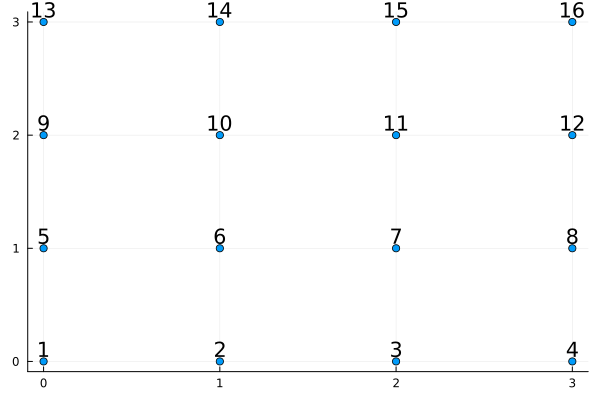

In [128]:
co = vcat( ( [y x] for x in 0:Nx-1 for y in 0:Ny-1 ) ... )
scatter(co[:,1],co[:,2], series_annotations = text.([i for i in 1:N_Site], :bottom), legend=false)

In [129]:
V0 = [4, 4]; Imp_Site = [13, 7]
Impurity_Data = Impurity(V0, Imp_Site)

Impurity([4.0, 4.0], [13, 7])

In [130]:
Impurity_H = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

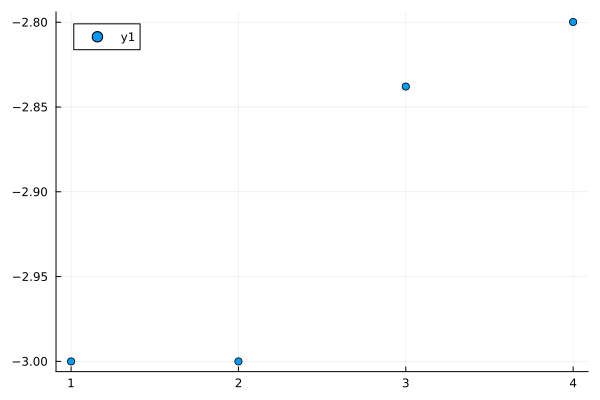

In [131]:
E_Imp, U_Imp = eigenstates(Impurity_H)
scatter(E_Imp[1:4])

# Filter

In [132]:
function Get_Filtered_Energies(Basis_Cut_MB, E_Imp, U_Imp, pn)
    Filtered_Energies = Array{Float64}(undef, length(E_Imp), 2)
    for i in 1:length(E_Imp)
        Filtered_Energies[i] = round(expect(number(Basis_Cut_MB), U_Imp[i])) 
        Filtered_Energies[i,2] = E_Imp[i] 
    end
    df = DataFrame(Filtered_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    return Matrix(df)[:,2]
end

Get_Filtered_Energies (generic function with 1 method)

In [133]:
Fil_Energies = Get_Filtered_Energies(Basis_Cut_MB, E_Imp, U_Imp, pn)
Fil_Energies;

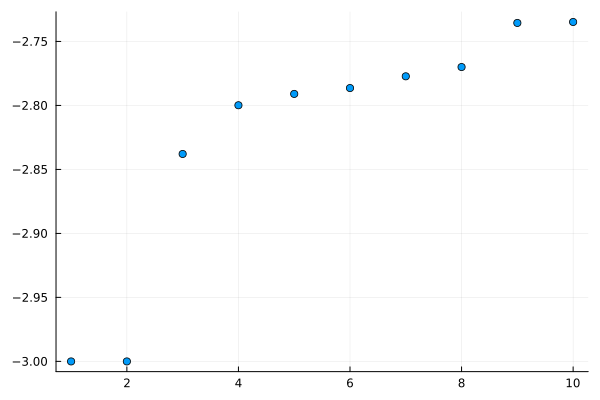

In [134]:
scatter(Fil_Energies[1:10], label=false)

In [135]:
function Get_Filtered_States(Fil_Energies, U_Imp)
    number_of_states = length(Fil_Energies)
    return U_Imp[1:number_of_states]
end

Get_Filtered_States (generic function with 1 method)

In [136]:
Fil_States = Get_Filtered_States(Fil_Energies, U_Imp);

# Density

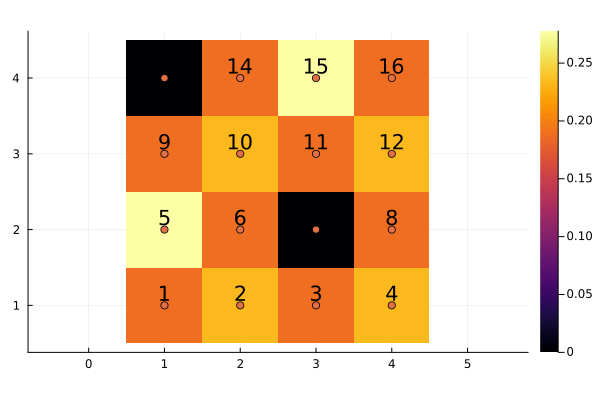

In [137]:
data = Get_Avg_Density(Nx, Ny, Degeneracy, N_Site, Sub_Number_MB_Operator_List, Basis_Cut_MB, Fil_States)'
factor = 1
Plots.heatmap(Interp(data, factor), aspect_ratio=:equal)
scatter!(co[:,1].+1,co[:,2].+1, series_annotations = text.([i for i in 1:N_Site], :bottom), legend=false)

In [138]:
Total_Particle_Number = sum(Get_Avg_Density(Nx, Ny, Degeneracy, N_Site, Sub_Number_MB_Operator_List, Basis_Cut_MB, Fil_States))

3.000000000000003

# Moving Quasiholes

In [139]:
start_point_1 = Impurity_Data.Imp_Site[1]
lens_1 = [1, 1, 1, 1]
dirs_1 = [1,-Ny,1,-Ny]
rec_path_1 = rectangular_path(start_point_1,lens_1,dirs_1)
rec_path_1 = unique(rec_path_1)
#rec_path_1 = push!(rec_path_1, start_point_1)

5-element Vector{Int64}:
 13
 14
 10
 11
  7

In [140]:
start_point_2 = Impurity_Data.Imp_Site[2]
lens_2 = [1, 1,]
dirs_2 = [1,-Ny]
rec_path_2 = rectangular_path(start_point_2,lens_2,dirs_2)
rec_path_2 = unique(rec_path_2)
#rec_path_2 = push!(rec_path_2, start_point_2)
push!(rec_path_2,1,13)

5-element Vector{Int64}:
  7
  8
  4
  1
 13

# Berry Matrix

In [141]:
V1 = Impurity_Data.V0[1]
V2 = Impurity_Data.V0[2]
delta_t = 0.05

0.05

In [142]:
STEP = 0:delta_t:1
length(STEP)

21

In [143]:
BerryMatrix = Berry_Matrix(rec_path_1, rec_path_2, Degeneracy, delta_t)
BerryEnergies, BerryStates = eigen(BerryMatrix)
angle.(BerryEnergies)/pi

0.0%┣                                                ┫ 0/4 [00:00<00:00, -0s/it]
50.0%┣███████████████████████▌                       ┫ 2/4 [00:00<00:00, 13it/s]
100.0%┣██████████████████████████████████████████████┫ 4/4 [00:00<00:00, 20it/s]
100.0%┣██████████████████████████████████████████████┫ 4/4 [00:00<00:00, 20it/s]
0.0%┣                                                ┫ 0/4 [00:00<00:00, -0s/it]
50.0%┣███████████████████████▌                       ┫ 2/4 [00:00<00:00, 16it/s]
100.0%┣██████████████████████████████████████████████┫ 4/4 [00:00<00:00, 25it/s]
100.0%┣██████████████████████████████████████████████┫ 4/4 [00:00<00:00, 25it/s]


2-element Vector{Float64}:
 -0.9999999999999958
  5.69905914704693e-16

In [144]:
BerryEnergies

2-element Vector{ComplexF64}:
 -1.0000000000254885 - 1.3281907225328549e-14im
  0.9999999999745116 + 1.790412234828e-15im

In [89]:
U_Imp_0, U_first, eig_list = get_final_state(rec_path_1, rec_path_2, Degeneracy, delta_t);

0.0%┣                                                ┫ 0/4 [00:00<00:00, -0s/it]
25.0%┣██████████▊                                ┫ 1/4 [00:12<Inf:Inf, InfGs/it]


LoadError: InterruptException:

# Simulation

In [50]:
movie(delta_t, 50, Nx, Ny, Degeneracy, N_Site, Sub_Number_MB_Operator_List, Basis_Cut_MB, co)

!Nx and Ny must be equalt to each other!


0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
12.5%┣█████▍                                     ┫ 1/8 [00:00<Inf:Inf, InfGs/it]
25.0%┣████████████                                    ┫ 2/8 [00:01<00:04, 1it/s]
37.5%┣██████████████████                              ┫ 3/8 [00:01<00:03, 2it/s]
50.0%┣████████████████████████                        ┫ 4/8 [00:01<00:02, 2it/s]
62.5%┣██████████████████████████████                  ┫ 5/8 [00:02<00:01, 2it/s]
75.0%┣████████████████████████████████████            ┫ 6/8 [00:02<00:01, 2it/s]
87.5%┣██████████████████████████████████████████      ┫ 7/8 [00:03<00:00, 2it/s]
100.0%┣███████████████████████████████████████████████┫ 8/8 [00:03<00:00, 2it/s]
100.0%┣███████████████████████████████████████████████┫ 8/8 [00:03<00:00, 2it/s]
[ Info: Saved animation to /home/can/Kagome-Lattice/My Numerical Calculations/Many-Body/Kapit-Mueller/tmp.gif


# Charge Depletion Profile

In [271]:
coordinates_top_left, coordinates_top, coordinates_top_right, coordinates_left, coordinates_right, coordinates_bottom_left, coordinates_bottom, coordinates_bottom_right, co_districts = get_ghost_sites(co)
ref_coordinates = co
ref_site = 7
radius_list = get_radii(ref_coordinates, co, ref_site, N_Site);
All_Coordinates, X_Coordinates, Y_Coordinates, All_Coordinates_2 = get_all_sites(Nx, Ny, co);

In [272]:
# Hangi siteler, ilgili yarı-çap içerisinde, şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    ref_district = co # Center Distrinct
    Ref_Site_X = ref_district[:,1][ref_site]
    Ref_Site_Y = ref_district[:,2][ref_site]
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "get_eq_site" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, get_eq_site(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Inner_Sites (generic function with 1 method)

In [273]:
ref_den = pn/(Nx*Ny)

0.1875

In [274]:
function get_depletion_profile(radius_list, avg_density)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites(i)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((ref_den .- avg_density')))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile (generic function with 1 method)

In [275]:
depletion_prof = get_depletion_profile(radius_list, data)

6-element Vector{Any}:
 0.18749999999999914
 0.2955841276506699
 0.22296487418979105
 0.15250642939177894
 0.028146383684182374
 2.7755575615628914e-17

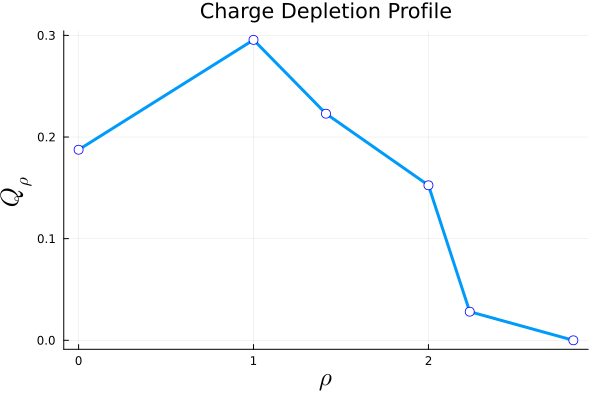

In [276]:
Plots.plot(radius_list, depletion_prof, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Charge Depletion Profile", guidefontsize=17,legend=false, linewidth=3, xticks=0:1:12, yticks=0:0.10:0.46, m = (5, :white, stroke(1, :blue)))